In [1]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

from torchvision import datasets, transforms
from torch.utils.data import random_split

from torchsummary import summary


import utils
from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
import utils.model as model
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.model import ClassifNet
from utils.utils import getLossAccuracyOnDataset
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [2]:
def img_show(img, cmap="gray", title=""):
    # cv.namedWindow(title, cv.WINDOW_NORMAL)
    # cv.imshow(title, img)
    print(title)
    plt.imshow(img, cmap)
    # display that image
    plt.show()


def tensor_to_image(tensor):
    transform = transforms.ToPILImage()
    return transform(tensor)


def image_to_tensor(image):
    transform_1 = transforms.ToPILImage()
    transform_2 = transforms.ToTensor()
    img_tensor = transform_2(transform_1(image))
    return img_tensor


In [3]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
# Refaire nos data folder et tout pour que ce soit
# au format demandé par le dataloader

training_set_name = "MNIST_STUDENT"+"_"+str(date)+"_"+str(heure)


dataset_folder = "xxx"
train_list = dataset_folder+"patches/xxx.txt"
test_list = dataset_folder+"patches/xxx.txt"


# Number of workers for dataloader
workers = 10

# Batch size during training (low batch_size if there are memory issues)
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
learning_rate = 1e-5  # e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Saves every batch_save_interval
batch_save_interval = 2

# some net variable
amp = False


saving_folder = "../Data/Saves/" + training_set_name

# We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
if not os.path.exists(saving_folder):
    os.mkdir(saving_folder)
    os.mkdir(saving_folder+"/loss-dice_listes")
    os.mkdir(saving_folder+"/newtork_weigths")
    os.mkdir(saving_folder+"/training_monitoring")

log_file = open(saving_folder+"/log+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("dataset_folder :"+dataset_folder+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_net="+str(learning_rate)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")
log_file.close()


In [4]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

# On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("device ID", device)
print("nom du GPU", torch.cuda.get_device_name(device))  # On vérifie son "nom"

torch.cuda.empty_cache()


number of gpus : 1
device ID cuda:0
nom du GPU NVIDIA GeForce GTX 1080 Ti


Number of entries 60000
Number of training entries 42000
Number of testing entries 9000
Number of validation entries 9000
SUM = 60000
0 8
1 9
2 1
3 8
4 7
5 8
6 1
7 7
8 9
9 7


/home/jonas/miniconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Size after filtering:
37611
33767
29577
25437
Sample of classes contained in filtered 7 :
tensor([4, 1, 1, 0, 5, 8, 3, 3, 0, 3])
Sample of classes contained in filtered 7 5 9 2: 
tensor([0, 0, 4, 1, 3, 1, 4, 4, 2, 1])
images source :  torch.Size([10, 1, 28, 28])
mask source : torch.Size([10])
tensor([5, 1, 1, 9, 3, 6, 1, 1, 9, 8])


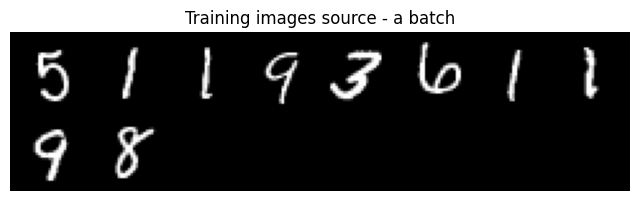

In [5]:
# For data augmentation

geometric_augs = [
    # transforms.Resize((256, 256)), # Makes it easier to process using net
    # transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(45),
]

color_augs = [
    # transforms.ColorJitter(hue=0.05, saturation=0.4)
]


def make_tfs(augs):
    return transforms.Compose([transforms.ToPILImage()]+augs + [transforms.ToTensor()])


tfs = transforms.Compose(geometric_augs)

"""
# Importation des images et masques de i3
dataset = SegmentationDataSet(root=dataset_folder,
                              list_path=train_list,
                              transform_img=make_tfs(
                                  geometric_augs + color_augs),
                              transform_label=make_tfs(geometric_augs)
                              )
"""

torch.set_grad_enabled(True)

data = dset.MNIST("/var/tmp/", train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(
                          (0.1307,), (0.3081,))
                  ]))

n_entries = len(data)
train_split = 70/100
validation_split = 50/100

n_train = int(train_split*n_entries)
n_test = int(((1-train_split)*(1-validation_split))*n_entries)
n_validation = int(((1-train_split)*(validation_split))*n_entries)

if (n_train + n_test + n_validation) != n_entries:
    # Add one to the validation set
    n_validation+=1

print("Number of entries", n_entries)
print("Number of training entries", n_train)
print("Number of testing entries", n_test)
print("Number of validation entries", n_validation)
print("SUM =", n_train+n_test+n_validation)

train_data, test_data, validation_data = random_split(
    data, [n_train, n_test, n_validation])


filtered_7_indices = []
filtered_7_5_indices = []
filtered_7_5_9_indices = []
filtered_7_5_9_2_indices = []
for i in range(len(train_data)):
    data_class = train_data[i][1]
    if data_class != 7:
        filtered_7_indices.append(i)
        if data_class != 5:
            filtered_7_5_indices.append(i)
            if data_class != 9:
                filtered_7_5_9_indices.append(i)
                if data_class != 2:
                    filtered_7_5_9_2_indices.append(i)

    if i < 10:
        print(i, train_data[i][1])


filtered_7_train_data = torch.utils.data.Subset(train_data, filtered_7_indices)
filtered_7_5_train_data = torch.utils.data.Subset(train_data, filtered_7_5_indices)
filtered_7_5_9_train_data = torch.utils.data.Subset(train_data, filtered_7_5_9_indices)
filtered_7_5_9_2_train_data = torch.utils.data.Subset(
    train_data, filtered_7_5_9_2_indices)


print("Size after filtering:")
print(len(filtered_7_train_data))
print(len(filtered_7_5_train_data))
print(len(filtered_7_5_9_train_data))
print(len(filtered_7_5_9_2_train_data))


# Dataloader
filtered_7_train_dataloader = torch.utils.data.DataLoader(filtered_7_train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=workers)

filtered_7_5_train_dataloader = torch.utils.data.DataLoader(filtered_7_5_train_data,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=workers)

filtered_7_5_9_train_dataloader = torch.utils.data.DataLoader(filtered_7_5_9_train_data,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=workers)

filtered_7_5_9_2_train_dataloader = torch.utils.data.DataLoader(filtered_7_5_9_train_data,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              num_workers=workers)


print("Sample of classes contained in filtered 7 :")
print(next(iter(filtered_7_train_dataloader))[1])
print("Sample of classes contained in filtered 7 5 9 2: ")
print(next(iter(filtered_7_5_9_2_train_dataloader))[1])


train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)

validation_dataloader = torch.utils.data.DataLoader(validation_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)


batch = next(iter(train_dataloader))

# On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
print("images source : ", batch[0].shape)
print("mask source :", batch[1].shape)


print(batch[1])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images source - a batch")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(
    device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# Neural net architecture

## Load or create neural net

In [6]:
def load_student_model():
    # STUDENT
    student_model = model.StudentNetworkSmall(1, 10)
    # Load NN
    if False:
        state_dict = torch.load(
            "")
        student_model.load_state_dict(state_dict)
    student_model.to(device=device)

    if (device.type == 'cuda') and (ngpu > 1):
        print("Data Parallel")
        student_model = nn.DataParallel(student_model, list(range(ngpu)))
    
    return student_model


def load_teacher_model():
    # TEACHER
    teacher_model = model.TeacherNetwork(1, 10)
    # Load NN
    if True:
        state_dict = torch.load(
            "../Data/Saves/MNIST_TEACHER/newtork_weigths/net_epoch8_acc0.997_loss0.011.pth")
        teacher_model.load_state_dict(state_dict)
    teacher_model.to(device=device)

    if (device.type == 'cuda') and (ngpu > 1):
        print("Data Parallel")
        teacher_model = nn.DataParallel(teacher_model, list(range(ngpu)))

    return teacher_model


# Other


# On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

print("Teacher network summary")
summary(load_teacher_model(), (1, 28, 28))

print("Student network summary")
summary(load_student_model(), (1, 28, 28))


We are running U-Net on : NVIDIA GeForce GTX 1080 Ti
Teacher network summary
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1200]                942,000
├─Linear: 1-2                            [-1, 1200]                1,441,200
├─Linear: 1-3                            [-1, 10]                  12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
Total mult-adds (M): 2.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 9.14
Estimated Total Size (MB): 9.16
Student network summary
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 30]                  23,550
├─Linear: 1-2                            [-1, 10]                  310
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Param

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 30]                  23,550
├─Linear: 1-2                            [-1, 10]                  310
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09

## Training

In [7]:
def trainStep(model, data, optimizer):
	"""
	One training step of the network: forward prop + backprop + update parameters
	Return: (loss, accuracy) of current batch
	"""
	X, y = data

	X = X.to(
            device=device, dtype=torch.float32)
	y = y.to(
		device=device, dtype=torch.long)
	
	optimizer.zero_grad()
	pred = model(X)
	loss = F.cross_entropy(pred, y)
	loss.backward()
	optimizer.step()
	accuracy = float(torch.sum(torch.argmax(
		pred, dim=1) == y).item()) / y.shape[0]
	return loss, accuracy


def validateStep(model, data):
	X, y = data

	X = X.to(
            device=device, dtype=torch.float32)
	y = y.to(
		device=device, dtype=torch.long)

	pred = model(X)
	loss = F.cross_entropy(pred, y).item()
	accuracy = float(torch.sum(torch.argmax(
		pred, dim=1) == y).item()) / y.shape[0]
	return loss, accuracy


teacher_model = load_teacher_model()


def studentTrainStepDistillationMNIST(model, data, optimizer):
	"""
	One training step of student network: forward prop + backprop + update parameters
	Return: (loss, accuracy) of current batch
	"""
	
	X, y = data

	X = X.to(
            device=device, dtype=torch.float32)
	y = y.to(
		device=device, dtype=torch.long)
	
	T = 1.0  # temperature for distillation loss
	# Using a higher value for T produces a softer probability distribution over classes
	alpha = 1.0
	# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
	# loss = alpha * st + (1 - alpha) * tt
	optimizer.zero_grad()
	teacher_pred = None
	if (alpha > 0):
		with torch.no_grad():
			teacher_model.eval()
			teacher_pred = teacher_model(X)
	student_pred = model(X)
	loss = studentLoss(teacher_pred, student_pred, y, T, alpha)
	loss.backward() # Generates error : element 0 of tensors does not require grad and does not have a grad_fn
	optimizer.step()
	accuracy = float(torch.sum(torch.argmax(
		student_pred, dim=1) == y).item()) / y.shape[0]
	return loss, accuracy



def studentTrainStep(teacher_net, student_net, studentLossFunction, optimizer, X, y, T, alpha):
	"""
	One training step of student network: forward prop + backprop + update parameters
	Return: (loss, accuracy) of current batch
	"""
	optimizer.zero_grad()
	teacher_pred = None
	if (alpha > 0):
		with torch.no_grad():
			teacher_pred = teacher_net(X)
	student_pred = student_net(X)
	loss = studentLossFunction(teacher_pred, student_pred, y, T, alpha)
	loss.backward()
	optimizer.step()
	accuracy = float(torch.sum(torch.argmax(
		student_pred, dim=1) == y).item()) / y.shape[0]
	return loss, accuracy

def studentLoss(teacher_pred, student_pred, y, T, alpha):
	"""
		Loss function for student network: Loss = alpha * (distillation loss with soft-target) + (1 - alpha) * (cross-entropy loss with true label)
		Return: loss
		"""
	if (alpha > 0):
		loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1),
						reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, y) * (1 - alpha)
	else:
		loss = F.cross_entropy(student_pred, y)
	return loss


In [8]:
# Training Function 
def train(model, train_loader, validate_loader, trainStepFun, validateStepFun):
    
    scheduler_params = dict(max_lr=1e-3,
                            epochs=num_epochs, steps_per_epoch=len(train_loader))

    optimizer = optim.AdamW(list(model.parameters()))
    scheduler_global = optim.lr_scheduler.OneCycleLR(
        optimizer, **scheduler_params)  # goal: maximize Dice score
    grad_scaler_global = torch.cuda.amp.GradScaler(
        enabled=amp)  # Default parameter
    
    best_accuracy = 0.0
    interval = []
    interval_count = 0
    validation_accuracy_progression = []
    validation_loss_progression = []
    print("Begin training...") 
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_vall_loss = 0.0
        total = 0

        # Training Loop
        for data in train_loader: 
        #for data in enumerate(train_loader, 0): 
            model.train()
            loss, acc = trainStepFun(model, data, optimizer)
            running_train_loss += loss #  # track the loss value
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_loader) 
        
        
        # Validation Loop 
        with torch.no_grad(): # Why not ?
            for data in validate_loader:
                model.eval()
                ## loss, acc = trainStepFun(model, data)
                loss, acc = validateStepFun(model, data)

                # The label with the highest value will be our prediction 
                running_vall_loss += loss
                total += 1
                running_accuracy += acc
                                            
                validation_accuracy_progression.append(acc)
                validation_loss_progression.append(loss)
                interval_count += 1
                interval.append(interval_count)
    
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validate_loader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100.0 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), saving_folder +
                       "/newtork_weigths/model_epoch{:}_validation_accuracy{:.3f}_train_loss{:.3f}.pth".format(epoch, accuracy, train_loss_value))
            best_accuracy = accuracy
         
        # Print the statistics of the epoch 
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value,
               'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))
        
        validation_accuracy_smooth = smooth(validation_accuracy_progression, 0.99)
        validation_loss_smooth = smooth(validation_loss_progression, 0.99)

        plt.figure(1)
        plt.clf()
        plt.plot(interval, validation_accuracy_smooth,
                 'g-', label='Global accuracy')
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy Value")
        plt.title("Accuracy Monitoring among validation")
        plt.legend()
        plt.savefig(saving_folder+"/training_monitoring/accuracy_" +
                    str(epoch)+"_epoch.png")
        
        if (epoch == num_epochs):
            plt.show()

        plt.figure(1)
        plt.clf()
        plt.plot(interval, validation_loss_smooth,
                 'r-', label='Global loss')
        plt.xlabel("Iterations")
        plt.ylabel("Loss Value")
        plt.title("Loss Monitoring among validation")
        plt.legend()
        plt.savefig(saving_folder+"/training_monitoring/loss_" +
                    str(epoch)+"_epoch.png")
        
        if (epoch == num_epochs):
            plt.show()




In [9]:
# Function to test the model
def test(model, test_loader):
    running_accuracy = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            outputs = outputs.to(torch.float32)
            predicted_outputs = model(inputs)
            _, predicted = torch.max(predicted_outputs, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()

        print('Accuracy of the model based on the test set',
              'inputs is: %d %%' % (100 * running_accuracy / total))


In [10]:
print("With trainStep")

#print("Teacher")
#train(load_teacher_model(), train_dataloader, validation_dataloader,
#      trainStep, validateStep)

print("Normal")
train(load_student_model(), train_dataloader, validation_dataloader,
      trainStep, validateStep)

print("7 Filtering")
train(load_student_model(), filtered_7_train_dataloader, validation_dataloader,
      trainStep, validateStep)

print("7 5 Filtering")
train(load_student_model(), filtered_7_5_train_dataloader, validation_dataloader,
      trainStep, validateStep)

print("7 5 9 Filtering")
train(load_student_model(), filtered_7_5_9_train_dataloader, validation_dataloader,
      trainStep, validateStep)

print("7 5 9 2 Filtering")
train(load_student_model(), filtered_7_5_9_2_train_dataloader, validation_dataloader,
      trainStep, validateStep)


print("With studentTrainStepDistillationMNIST")

print("Normal")
train(load_student_model(), train_dataloader, validation_dataloader,
      studentTrainStepDistillationMNIST, validateStep)

print("7 Filtering")
train(load_student_model(), filtered_7_train_dataloader, validation_dataloader,
      studentTrainStepDistillationMNIST, validateStep)

print("7 5 Filtering")
train(load_student_model(), filtered_7_5_train_dataloader, validation_dataloader,
      studentTrainStepDistillationMNIST, validateStep)

print("7 5 9 Filtering")
train(load_student_model(), filtered_7_5_9_train_dataloader, validation_dataloader,
      studentTrainStepDistillationMNIST, validateStep)

print("7 5 9 2 Filtering")
train(load_student_model(), filtered_7_5_9_2_train_dataloader, validation_dataloader,
      studentTrainStepDistillationMNIST, validateStep)



With trainStep
Normal


TypeError: unsupported operand type(s) for ** or pow(): 'AdamW' and 'dict'

In [ ]:
"""global_step =  0
n_train = len(filtered_train_data)
print(n_train)

T = 1.0 # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 1.0
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

print("Starting Training Loop...")


source_dice = []
intervalle = []

L_seg_list = []

loss_list = []
acc_list = []

L_s_list = []

compteur_plot = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    cpt_it = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='img') as pbar:

        for i, data in enumerate(filtered_train_dataloader, 0):
            student_model.train()
            teacher_model.eval()

            cpt_it += 1

            X, y = data

            X = X.to(
                device=device, dtype=torch.float32)
            y = y.to(
                device=device, dtype=torch.long)

            # Pass Data Trought net before optimizing everything

            loss, acc = studentTrainStep(teacher_model, student_model, studentLoss, optimizer_global, X, y, T, alpha)
            

            L_global = loss

            ###########################################################
            # Evaluation on the Training Set
            ###########################################################

            student_model.eval()

            intervalle.append(compteur_plot)
            compteur_plot += 1

            global_step += 1
            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.update(X.shape[0])
            pbar.set_postfix(
                **{'loss (batch)': epoch_loss/cpt_it, "accuracy (batch)": epoch_acc/cpt_it})
            # pbar.set_postfix(**{'dice target': dice_target})

            loss_list.append(loss.item())
            acc_list.append(acc)
# print("whole epoch target dice mean :", sum(dice_score_target)/cpt_it)
        if (epoch % batch_save_interval == 0):  # and epoch != 0 :

            loss_smooth = smooth(loss_list, 0.99)
            acc_smooth = smooth(acc_list, 0.99)

            torch.save(student_model.state_dict(), saving_folder +
                       "/newtork_weigths/net_epoch{:}_acc{:.3f}_loss{:.3f}.pth".format(epoch, epoch_acc/cpt_it, epoch_loss/cpt_it))

            plt.figure(1)
            plt.clf()
            plt.plot(intervalle, acc_smooth, 'r-', label='Global accuracy')
            plt.xlabel("iterations")
            plt.ylabel("Accuracy Value")
            plt.title("Accuracy Monitoring among training")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/acc_" +
                        str(epoch)+"_epoch.png")
            plt.show()

            plt.figure(1)
            plt.clf()
            plt.plot(intervalle, loss_smooth, 'r-', label='Global loss')
            plt.xlabel("iterations")
            plt.ylabel("Loss Value")
            plt.title("Loss Monitoring among training")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/loss_" +
                        str(epoch)+"_epoch.png")
            plt.show()"""
